# 2.2.0 Creating MDS Plots for PredNet

Creating MDS (or some other dim redux) plots on the nodes 

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Thu Aug 20 2020 23:41:42 

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : apra-x3
Git hash   : 5cafa0acbc4acc44b502d14c1844366f4149e591
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [4]:
import gc
import logging
from argparse import Namespace
from pathlib import Path

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from PIL import Image, ImageOps
from torch.utils.data import IterableDataset, DataLoader

%aimport prevseg.constants
import prevseg.constants as const
%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.dataloaders.schapiro
import prevseg.dataloaders.schapiro as sch
%aimport prevseg.schapiro
from prevseg.schapiro import walk, graph
%aimport prevseg.models.prednet
import prevseg.models.prednet as prednet

# Keep track of versions of everything
%watermark -v -iv

pytorch_lightning 0.8.5
PIL.Image         7.2.0
numpy             1.19.1
torch             1.6.0
prevseg           0+untagged.45.g5cafa0a.dirty
logging           0.5.1.2
networkx          2.4
CPython 3.8.5
IPython 7.16.1


## Returning the Labels (Graph Path)

Realized it would be useful to have the graph position at each step, so modifying the dataset to return that as well.

In [5]:
max_steps = 2
epochs = 2
batch_size = 2
n_paths = 2

iter_ds = sch.ShapiroFractalsDataset(
    batch_size=batch_size, 
    max_steps=max_steps,
    n_paths=n_paths)
loader = DataLoader(iter_ds, batch_size=None)
for _ in range(epochs):
    for i, batch in enumerate(loader):
        print(i, batch.shape)
        if i == n_paths:
            print('bad')
            break

Created mapping as follows:
{0: '26', 1: '32', 2: '8', 3: '71', 4: '98', 5: '79', 6: '29', 7: '16', 8: '19', 9: '25', 10: '72', 11: '10', 12: '81', 13: '77', 14: '12'}
0 torch.Size([2, 2, 128, 128])
1 torch.Size([2, 2, 128, 128])
0 torch.Size([2, 2, 128, 128])
1 torch.Size([2, 2, 128, 128])


In [6]:
class ShapiroFractalsDataset(IterableDataset):
    modes = set(('random', 'euclidean', 'hamiltonian'))
    def __init__(self, batch_size=32, n_pentagons=3, max_steps=128, n_paths=128, mapping=None, 
                 mode='random'):
        self.batch_size = batch_size
        self.n_pentagons = n_pentagons
        self.max_steps = max_steps
        self.n_paths = n_paths
        self.mapping = mapping
        self.mode = mode
        assert self.mode in self.modes
        
        self.G = graph.schapiro_graph(n_pentagons=n_pentagons)
        
        self.load_node_stimuli()
        
        self.mapping = {node : path.stem
                        for node, path in zip(range(len(self.G.nodes)),
                                              self.paths_data)}
        print(f'Created mapping as follows:\n{self.mapping}')    
        
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS / (name+'.tiff')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array(
            [np.array(ImageOps.grayscale(Image.open(str(path))))
             for path in self.paths_data])
        
    def iter_single_sample(self): 
        if self.mode == 'random':
            iter_walk = walk.walk_random(self.G, steps=self.max_steps)
        elif self.mode == 'euclidean':
            iter_walk = walk.walk_euclidean(self.G)
        elif self.mode == 'hamiltonian':
            iter_walk = walk.walk_hamiltonian(self.G)
        
        for sample in iter_walk:
            yield self.array_data[sample[0]], sample[0]
        
    def iter_batch_sample(self):
        iter_batch = zip(*[self.iter_single_sample() for _ in range(self.batch_size)])
        for batch in iter_batch:
            data, nodes = zip(*batch)
            yield data, nodes
        
    def iter_batch_dataset(self):   
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
        
    def __iter__(self):
        return self.iter_batch_dataset()

    
max_steps = 5
epochs = 2
batch_size = 2
n_paths = 3

iter_ds = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths)
loader = DataLoader(iter_ds, batch_size=None)
for _ in range(epochs):
    for i, batch in enumerate(loader):
        print(i, batch[0].shape, batch[1])
        if i == n_paths:
            print('bad')
            break
            
mapping = iter_ds.mapping

Created mapping as follows:
{0: '52', 1: '13', 2: '39', 3: '31', 4: '19', 5: '95', 6: '23', 7: '35', 8: '80', 9: '24', 10: '92', 11: '65', 12: '34', 13: '27', 14: '53'}
0 torch.Size([2, 5, 128, 128]) [[14, 10], [12, 13], [13, 11], [10, 14], [12, 12]]
1 torch.Size([2, 5, 128, 128]) [[12, 14], [14, 12], [11, 11], [13, 14], [12, 0]]
2 torch.Size([2, 5, 128, 128]) [[2, 8], [1, 9], [2, 10], [4, 13], [2, 14]]
0 torch.Size([2, 5, 128, 128]) [[11, 2], [14, 4], [0, 1], [3, 0], [2, 2]]
1 torch.Size([2, 5, 128, 128]) [[4, 10], [1, 13], [2, 14], [4, 0], [5, 3]]
2 torch.Size([2, 5, 128, 128]) [[8, 14], [6, 0], [8, 3], [6, 4], [5, 1]]


In [7]:
max_steps = 5
epochs = 2
batch_size = 3
n_paths = 2

class ShapiroResnetEmbeddingDataset(ShapiroFractalsDataset):
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS_EMB / (name+'.npy')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS_EMB.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array(
            [np.array(np.load(str(path)))
             for path in self.paths_data])    

iter_ds = ShapiroResnetEmbeddingDataset(
    batch_size=batch_size, 
    max_steps=max_steps, 
    n_paths=n_paths,
    mapping=mapping,
)
loader = DataLoader(iter_ds, batch_size=None)

for _ in range(epochs):
    for i, batch in enumerate(loader):
        print(i, batch[0].shape, batch[1])
        if i == n_paths:
            print('bad')
            break

Created mapping as follows:
{0: '52', 1: '13', 2: '39', 3: '31', 4: '19', 5: '95', 6: '23', 7: '35', 8: '80', 9: '24', 10: '92', 11: '65', 12: '34', 13: '27', 14: '53'}
0 torch.Size([3, 5, 2048]) [[7, 12, 1], [8, 13, 0], [6, 12, 3], [5, 11, 2], [7, 13, 4]]
1 torch.Size([3, 5, 2048]) [[9, 6, 10], [6, 7, 12], [8, 6, 13], [9, 8, 12], [7, 5, 14]]
0 torch.Size([3, 5, 2048]) [[14, 11, 4], [12, 10, 5], [14, 9, 8], [0, 7, 5], [2, 8, 7]]
1 torch.Size([3, 5, 2048]) [[6, 0, 14], [8, 1, 11], [7, 3, 13], [9, 4, 12], [8, 5, 10]]


## Redefining PredNet Class

In [10]:
class PredNetTracked(prednet.PredNetTracked):
    def prepare_data(self):
        self.ds = self.ds or ShapiroResnetEmbeddingDataset(
            batch_size=self.batch_size, 
            n_pentagons=self.hparams.n_pentagons, 
            max_steps=self.hparams.max_steps, 
            n_paths=self.hparams.n_paths)
        self.ds_val = ShapiroResnetEmbeddingDataset(
            batch_size=self.batch_size, 
            n_pentagons=self.hparams.n_pentagons,
            n_paths=1,
            mapping=self.ds.mapping,
            mode='euclidean')
        
#         n_test, n_val = self.hparams.n_test, self.hparams.n_val
        
    def train_dataloader(self):
        return DataLoader(self.ds, 
                          batch_size=None,
                          num_workers=self.hparams.n_workers)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, 
                          batch_size=None,
                          num_workers=self.hparams.n_workers)

## Loading Saved Weights

In [35]:
model, trainer = None, None
train_dataloader, val_dataloader = None, None
errors, optimizer = None, None
ckpt = None
train_errors, val_errors = None, None
res = None
gc.collect()
torch.cuda.empty_cache()

model = PredNetTracked.load_from_checkpoint(str(
    index.DIR_CHECKPOINTS / 
    'prednet_tracked_schapiro_test_v46/schapiro_test_global_step=00127_epoch=003_val_loss=0.106.ckpt'),
)
model.prepare_data()
model.cuda()
hparams = model.hparams

log_dir = Path(hparams.dir_logs) / f'{hparams.name}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)
logger = pl.loggers.TensorBoardLogger(str(log_dir.parent), 
                                      name=hparams.name,
                                      version=0)
model.logger = logger

Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}
Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}


In [36]:
iter_ds = ShapiroResnetEmbeddingDataset(
    batch_size=1, 
    max_steps=hparams.max_steps, 
    n_paths=1,
    mapping=model.ds.mapping,
    mode='euclidean')
loader = DataLoader(iter_ds, batch_size=None)

for data, nodes in loader:
    pass

Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}


In [37]:
data.shape

torch.Size([1, 30, 2048])

In [73]:
data_all = torch.cat((data, torch.flip(data, (0,1))[:,1:,:]), 1)
data_all.shape

torch.Size([1, 59, 2048])

In [80]:
data_all[0,28,0]

tensor(0.0314)

In [78]:
data_all[0,29,0]

tensor(0.1979)

In [79]:
data_all[0,30,0]

tensor(0.0314)

In [74]:
outs = model.forward(data_all, output_mode='eval', run_num='fwd_rev', 
                     tb_labels=['nodes'])

In [40]:
nodes = np.array(nodes).reshape(30)
nodes

array([11, 13, 14, 12, 13, 10, 12, 11, 14,  0,  3,  4,  2,  3,  1,  2,  0,
        1,  4,  5,  8,  9,  7,  8,  6,  7,  5,  6,  9, 10])

In [75]:
nodes_all = np.concatenate((nodes, np.flip(nodes)[1:]))
nodes_all.shape

(59,)

In [76]:
for i, val in enumerate(nodes_all):
    print(i, val)

0 11
1 13
2 14
3 12
4 13
5 10
6 12
7 11
8 14
9 0
10 3
11 4
12 2
13 3
14 1
15 2
16 0
17 1
18 4
19 5
20 8
21 9
22 7
23 8
24 6
25 7
26 5
27 6
28 9
29 10
30 9
31 6
32 5
33 7
34 6
35 8
36 7
37 9
38 8
39 5
40 4
41 1
42 0
43 2
44 1
45 3
46 2
47 4
48 3
49 0
50 14
51 11
52 12
53 10
54 13
55 12
56 14
57 13
58 11


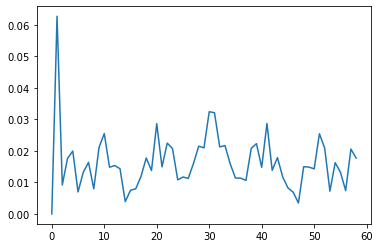

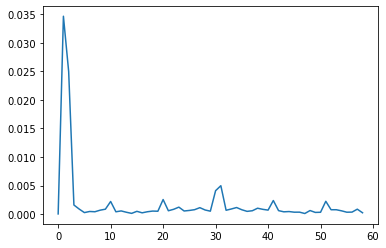

In [82]:
for out in outs['hidden_diff']:
    plt.plot(np.array(out.cpu()).reshape(59))
    plt.show()

Strange to get large shifts at 30 and 31. Unclear what that would mean.

In [93]:
test_nodes = [9,10,9,10,9,10,13,12,11,12,13,12,11,14,0,14,0,14,0,1,2,3,2,1,2,3,4,5,4,5,4,5,4]
test_data = np.array([iter_ds.array_data[n] for n in test_nodes]).reshape((1,len(test_nodes),2048))

In [94]:
border_outs = model.forward(torch.Tensor(test_data), output_mode='eval', run_num='border_walk_3', 
                            tb_labels=['nodes'])

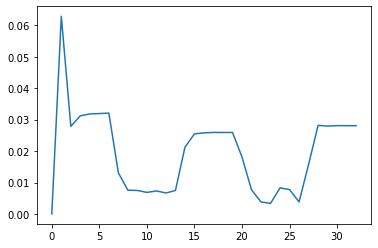

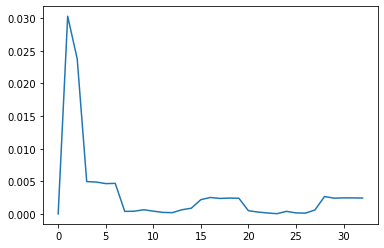

In [95]:
for out in border_outs['hidden_diff']:
    plt.plot(np.array(out.cpu()).reshape(len(test_nodes)))
    plt.show()

Seems its that some borders illicit a larger state change. Could be a result of the embeddings being more different than usual.